# Investigating the Re-use of subsamples from previous iterations

Context: a multi-fidelity optimization procedure where an Error Grid is created after every evaluation to determine the next best fidelity for evaluation. Each Error Grid is made up of 'pixels' $(n_h, n_l)$ where $n_h < N_H$ and $n_l < N_L$, where $N_H, N_L$ are the total number of high- and low-fidelity evaluations available and $n_h, n_l$ are the size of the subsample from that total.

The idea is as follows: In each iteration, a single new evaluation is added, i.e., $N_H += 1$ or $N_L += 1$. For each previously calculated Error Grid 'pixel' $(n_h, n_l)$, all subsamples used in that previous iteration are still valid subsamples: they simply happen to exclude the newly added point. Reusing these is therefore no problem in principle, but we want to avoid a bias from ignoring the new point (otherwise, what's the point in evaluating that in the first place if we don't bother learning from it). So the question is: if we were to uniformly at random draw a new set of subsamples based on the new $N_H$ or $N_L$, what percentage do we expect to **not** include the newest point? Assuming the previous set of subsamples is also drawn uniformly at random, a random subselection from those should suffice to be reused as that percentage for the new iteration. The remainder can then be drawn anew, with the explicit requirement that they should contain the new sample.

This procedure allows us to reuse some of the work from the previous iteration for all previously calculated pixels $(n_h, n_l)$, without introducing a bias towards including/excluding the newest sample.

(It must however be noted that this procedure is more 'exact' rather than an actual random distribution. While I don't expect this to cause a problem, this will have to be kept in mind in case it becomes relevant elsewhere in the process)

## Deriving formulas: how to calculate how much re-use is possible?

### Definitions/assumptions:

All high-fidelity samples are also evaluated in low-fidelity.

A subsample of size $(n_h, n_l)$ is created in two steps:
1. First a subsample of $n_h$ high-fidelity samples is drawn from the total number $N_H$. This means that the number of 'high-fidelity'-only subsamples is $N_H \choose n_h$
2. All high-fidelity samples are automatically included in the low-fidelity sample, meaning that only $n_l - n_h$ low-fidelity samples are left to be sampled from the $N_L - n_H$ remaining samples. This means the number of possible 'low-fidelity'-only subsamples after having drawn a 'high-fidelity'-only subsample is ${N_L - n_h} \choose {n_l - n_h}$

Since the drawing of the high- and low-fidelity subsamples are independent of eachother, the total number of subsamples for an Error Grid 'pixel' $n_h, n_l$ is ${N_H \choose n_h} \cdot {{N_L - n_h} \choose {n_l - n_h}}$



### Derivation of formulas

In [1]:
import sympy
sympy.init_printing()

NH, NL, nh, nl = sympy.symbols('N_H N_L n_h n_l')

#### For $N_L += 1$

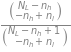

In [2]:
num_subsamples = sympy.binomial(NH, nh) * sympy.binomial(NL-nh, nl-nh)
more_subsamples = sympy.binomial(NH, nh) * sympy.binomial((NL+1)-nh, nl-nh)

ratio = num_subsamples / more_subsamples
ratio  # binom(NH, nh) cancels out

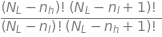

In [3]:
ratio.rewrite(sympy.factorial)

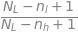

In [4]:
sympy.simplify(ratio.rewrite(sympy.factorial))  # simplify: (x+1)! / x! = x+1  and x! / (x+1)! = 1/(x+1)

#### For $N_H += 1$

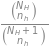

In [5]:
num_subsamples = sympy.binomial(NH, nh) * sympy.binomial(NL-nh, nl-nh)
more_subsamples = sympy.binomial((NH+1), nh) * sympy.binomial(NL-nh, nl-nh)

ratio = num_subsamples / more_subsamples
ratio  # binom(NL-nh, nl-nh) cancels out

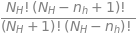

In [6]:
ratio.rewrite(sympy.factorial)

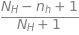

In [7]:
sympy.simplify(ratio.rewrite(sympy.factorial))  # simplify: (x+1)! / x! = x+1  and x! / (x+1)! = 1/(x+1)

#### Summary:

As can be seen in the derivations above, when adding a new low-fidelity sample, the fraction that can be reused is fairly simply defined by $\dfrac{N_L - n_l + 1}{N_L - n_h + 1}$, depending only on $N_L, n_h$ and $n_l$.

For the case of adding a high-fidelity sample, this is defined only as a relation between $N_H$ and $n_h$ by $\dfrac{N_H - n_h + 1}{N_H + 1}$ 

## Visual inspection of actual percentage reuse

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def reuse_after_low_add(nh, nl, NL):
    """calculate the fraction of subsamples that can be reused
    if the number of low-fidelity samples is increased by 1"""
    return (NL-nl+1)/(NL-nh+1)

def reuse_after_high_add(nh, NH):
    """calculate the fraction of subsamples that can be reused
    if the number of high-fidelity samples is increased by 1"""
    return (NH - nh + 1) / (NH + 1)

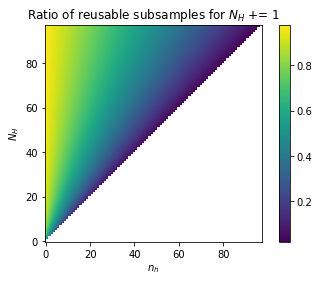

In [3]:
nh, NH = np.meshgrid(np.arange(2, 100), np.arange(3, 101))

ratio = reuse_after_high_add(nh, NH)
ratio[nh >= NH] = np.nan

fig = plt.figure()
ax = fig.gca()

img = ax.imshow(ratio, origin='lower')
ax.set_title('Ratio of reusable subsamples for $N_H$ += 1')
ax.set_xlabel('$n_h$')
ax.set_ylabel('$N_H$')
fig.colorbar(img)
fig.show()

In [13]:
from ipywidgets import interact, IntSlider
%matplotlib inline


def update(nh):
    nl, NL = np.meshgrid(np.arange(2, 250, dtype=float), np.arange(3, 251, dtype=float))
    nl[(nl <= nh) | (nl >= NL)] = np.nan
    NL[(nl <= nh) | (nl >= NL)] = np.nan
    
    ratio = reuse_after_low_add(nh, nl, NL)

    fig = plt.figure()
    ax = fig.gca()

    img = ax.imshow(ratio, origin='lower')
    ax.set_title(f'Ratio of reusable subsamples for $N_L$ += 1 ($n_h$ = {nh})')
    ax.set_xlabel('$n_l$')
    ax.set_ylabel('$N_L$')
    fig.colorbar(img)
    fig.show()

interact(update, nh=IntSlider(value=10, min=1, max=200, step=1))

interactive(children=(IntSlider(value=10, description='nh', max=200, min=1), Output()), _dom_classes=('widget-…

<function __main__.update(nh)>